In [12]:
import torch.nn.functional as F 
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import random
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from einops.layers.torch import Rearrange
import math
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage

In [13]:
class VAE(nn.Module):
    def __init__(self,input_dim,hid_dim=200,z_dim=20):
        super().__init__()

        #encoder
        self.img2hid=nn.Linear(input_dim,hid_dim)
        self.hid2sigma=nn.Linear(hid_dim,z_dim)
        self.hid2mu=nn.Linear(hid_dim,z_dim)

        #decoder
        self.z2hid=nn.Linear(z_dim,hid_dim)
        self.hid2img=nn.Linear(hid_dim,input_dim)

        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
    def encode(self, x):
        h=self.relu(self.img2hid(x))
        mu=self.hid2mu(h)
        sigma=self.hid2sigma(h)

        return mu, sigma
    
    def  decode(self, z):
        h=self.relu(self.z2hid(z))


        return self.sigmoid(self.hid2img(h))
    
    def forward(self, x):
        mu,sigma=self.encode(x)
        eps=torch.randn_like(sigma)
        z=mu+sigma*eps
        x_recon=self.decode(z)
        
        return x_recon, mu, sigma
    



    
    

    

In [14]:
device='cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
# training params
epochs=10
batch_size=64
lr=1e-4
z_dim=100
input_dim=784 #28x28
n_c=1

transform=transforms.Compose(transforms=[transforms.ToTensor()])
dataset=datasets.MNIST(root="data",transform=transform,download=True)
from sklearn.model_selection import train_test_split
train_dataset,val_dataset=train_test_split(dataset,test_size=0.1,random_state=42)
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)

model=VAE(input_dim=input_dim).to(device)

loss_recon=torch.nn.BCELoss(reduction='sum')

optimizer=torch.optim.Adam(model.parameters(),lr=lr)

loss_list=[]
loss_res_list=[]
loss_kl_list=[]


In [15]:
from tqdm.auto import tqdm

model.train()

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,_) in enumerate(train_loader):

    x=x.to(device).view(x.shape[0],1,-1)
    optimizer.zero_grad()
    x_recon,mu,sig=model(x)
    loss_res=loss_recon(x_recon,x)
    loss_kl=-torch.sum(torch.log(sig**2)-(mu**2)-(sig**2)+1)/2

    loss=loss_res+loss_kl
    loss_list.append(loss.item())
    loss_res_list.append(loss_res.item())
    loss_kl_list.append(loss_kl.item())
    loss.backward()
    optimizer.step()

    if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss res: {loss_res:.4f}, loss kl: {loss_kl:.4f}, loss VAE:{loss:.4f}"
            )

   

            



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0/10] Batch 0/844                   Loss res: 34800.5156, loss kl: 3045.6006, loss VAE:37846.1172
Epoch [1/10] Batch 0/844                   Loss res: 12962.5225, loss kl: 637.5551, loss VAE:13600.0771
Epoch [2/10] Batch 0/844                   Loss res: 10889.7656, loss kl: 747.0410, loss VAE:11636.8066
Epoch [3/10] Batch 0/844                   Loss res: 9681.0605, loss kl: 889.6141, loss VAE:10570.6748
Epoch [4/10] Batch 0/844                   Loss res: 8955.5166, loss kl: 988.8424, loss VAE:9944.3594
Epoch [5/10] Batch 0/844                   Loss res: 8398.9902, loss kl: 1007.7590, loss VAE:9406.7490
Epoch [6/10] Batch 0/844                   Loss res: 7079.4668, loss kl: 1123.0502, loss VAE:8202.5166
Epoch [7/10] Batch 0/844                   Loss res: 7406.4678, loss kl: 1215.9635, loss VAE:8622.4316
Epoch [8/10] Batch 0/844                   Loss res: 6874.6436, loss kl: 1202.7988, loss VAE:8077.4424
Epoch [9/10] Batch 0/844                   Loss res: 7110.5088, loss k

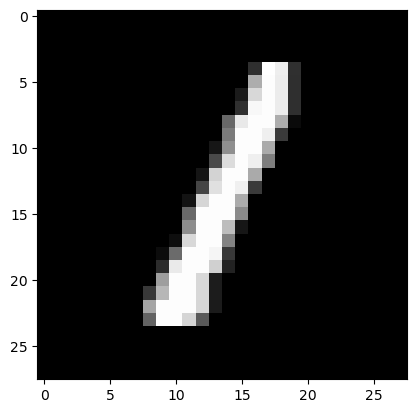

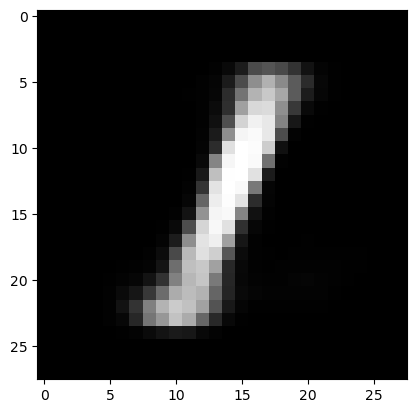

In [23]:
image,label=next(iter(train_loader))
import matplotlib.pyplot as plt


img=image[0].view(1,-1).to(device)
x_gen,mu,sig=model(img)
x_gen=x_gen.detach()
plt.imshow(image[0].permute(1,2,0).numpy(),cmap='gray')
plt.show()
plt.imshow(x_gen.view(1,28,-1).permute(1,2,0).cpu(),cmap='gray')
plt.show()



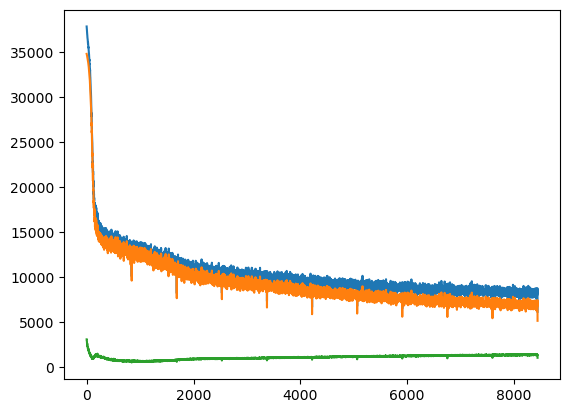

In [24]:
plt.plot(loss_list)
plt.plot(loss_res_list)
plt.plot(loss_kl_list)


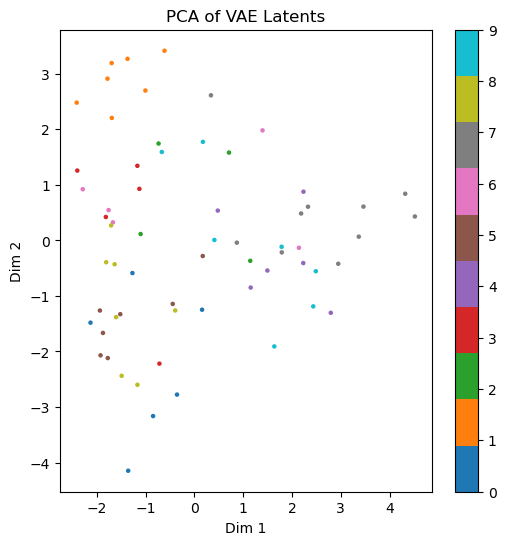

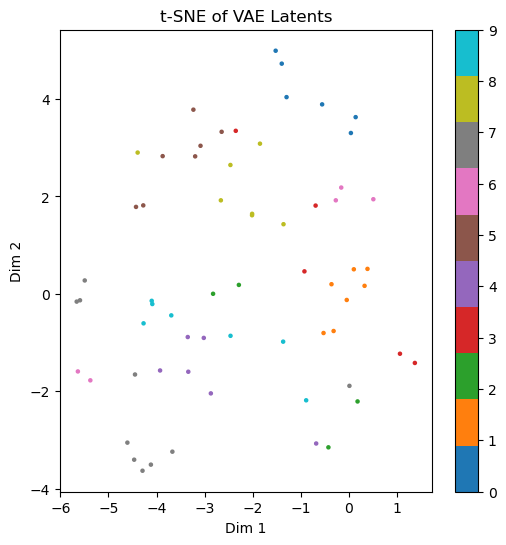

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

img=image.view(batch_size,1,-1).to(device)

x_recon,mu,sig=model(img)
x_recon=x_recon.detach()


z = mu.detach().cpu().numpy().reshape(batch_size,-1)      # shape (N, 2)
labels = label.cpu().numpy()   

# Option A: PCA → 2D
Z_pca = PCA(n_components=2).fit_transform(z)

# Option B: t-SNE → 2D
Z_tsne = TSNE(n_components=2, perplexity=30).fit_transform(z)

def plot(Z2d, title):
    plt.figure(figsize=(6,6))
    sc = plt.scatter(Z2d[:,0], Z2d[:,1], c=labels, s=5, cmap='tab10')
    plt.colorbar(sc)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

plot(Z_pca, 'PCA of VAE Latents')
plot(Z_tsne, 't-SNE of VAE Latents')
